In [66]:
# from opencv documentation (tutorial_py_calibration)
# actual calibration images not committed to repo, since they're ~10 MB each

import numpy as np
import cv2
import glob

length = 11
width = 8

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((length*width,3), np.float32)
objp[:,:2] = np.mgrid[0:length,0:width].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCornersSB(gray, (length,width), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        #cv2.drawChessboardCorners(img, (length,width), corners2, ret)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
cv2.destroyAllWindows()

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

np.save('ret.npy', ret)
np.save('mtx.npy', mtx)
np.save('dist.npy', dist)
np.save('rvecs.npy', rvecs)
np.save('tvecs.npy', tvecs)

done


In [2]:
# test calibration

import numpy as np
import cv2

ret = np.load('cal_results/ret.npy')
mtx = np.load('cal_results/mtx.npy')
dist = np.load('cal_results/dist.npy')
rvecs = np.load('cal_results/rvecs.npy')
tvecs = np.load('cal_results/tvecs.npy')

img = cv2.imread('aruco/setup1_img1.jpg')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('aruco_test.jpg', dst)

True

In [2]:
# undistort aruco test images

import numpy as np
import cv2
import glob

ret = np.load('cal_results/ret.npy')
mtx = np.load('cal_results/mtx.npy')
dist = np.load('cal_results/dist.npy')
rvecs = np.load('cal_results/rvecs.npy')
tvecs = np.load('cal_results/tvecs.npy')

images = glob.glob('aruco/raw/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    # undistort
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    fname_short = fname.rsplit("/")[2]
    cv2.imwrite('aruco/undistorted/' + fname_short, dst)

In [3]:
# aruco marker detection test w/thresholding and marking
# thx https://www.pyimagesearch.com/2020/12/21/detecting-aruco-markers-with-opencv-and-python/

import numpy as np
import cv2
import glob

aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_100)
# marker created via cv2.aruco.drawMarker(aruco_dict, 1, 8)
images = glob.glob('aruco/undistorted/test/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,gray_thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
    fname_short = fname.rsplit("/")[2]
    aruco_params = cv2.aruco.DetectorParameters_create()
    (corners, ids, rejected) = cv2.aruco.detectMarkers(gray_thresh, aruco_dict, parameters=aruco_params)

    # loop over the detected ArUCo corners
    for (markerCorner, markerID) in zip(corners, ids):
    # extract the marker corners (which are always returned in
    # top-left, top-right, bottom-right, and bottom-left order)
        corners = markerCorner.reshape((4, 2))
        (topLeft, topRight, bottomRight, bottomLeft) = corners
        # convert each of the (x, y)-coordinate pairs to integers
        topRight = (int(topRight[0]), int(topRight[1]))
        bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
        bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
        topLeft = (int(topLeft[0]), int(topLeft[1]))
        
    # draw the bounding box of the ArUCo detection
    cv2.line(img, topLeft, topRight, (0, 255, 0), 6)
    cv2.line(img, topRight, bottomRight, (0, 255, 0), 6)
    cv2.line(img, bottomRight, bottomLeft, (0, 255, 0), 6)
    cv2.line(img, bottomLeft, topLeft, (0, 255, 0), 6)
    # compute and draw the center (x, y)-coordinates of the ArUco
    # marker
    cX = int((topLeft[0] + bottomRight[0]) / 2.0)
    cY = int((topLeft[1] + bottomRight[1]) / 2.0)
    cv2.circle(img, (cX, cY), 12, (0, 0, 255), -1)
    # draw the ArUco marker ID on the image
    cv2.putText(img, str(markerID),(topLeft[0], topLeft[1] - 15), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255, 0), 2)
    print("[INFO] ArUco marker ID: {}".format(markerID))
    # show the output image
    cv2.imshow("Image", cv2.resize(img,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imwrite('test_inaccurate.jpg', img)

NameError: name 'topLeft' is not defined

In [14]:
# aruco marker center detection
# thx https://www.pyimagesearch.com/2020/12/21/detecting-aruco-markers-with-opencv-and-python/

import numpy as np
import cv2
import glob

aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_100)
# marker created via cv2.aruco.drawMarker(aruco_dict, 1, 8)
images = glob.glob('aruco/undistorted/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,gray_thresh = cv2.threshold(gray,50,255,cv2.THRESH_BINARY)
    fname_short = fname.rsplit("/")[2]
    aruco_params = cv2.aruco.DetectorParameters_create()
    corners = cv2.aruco.detectMarkers(gray_thresh, aruco_dict, parameters=aruco_params)
    cX = (corners[0][0][0][0][0] + corners[0][0][0][2][0]) / 2.0
    cY = (corners[0][0][0][0][1] + corners[0][0][0][2][1]) / 2.0
    cv2.circle(img, (int(cX), int(cY)), 12, (0, 0, 255), -1)
    print((fname_short,cX,cY))
    #cv2.imshow("Image", cv2.resize(img,None,fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA))
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

('setup4_img2.jpg', 3314.5, 1382.5)
('setup5_img5.jpg', 1966.0, 1592.5)
('setup5_img7.jpg', 1899.5, 1492.5)
('setup2_img7.jpg', 3158.0, 2333.5)
('setup3_img9.jpg', 842.0, 1569.5)
('setup5_img2.jpg', 2153.5, 1879.5)
('setup1_img6.jpg', 1118.5, 964.5)
('setup3_img8.jpg', 839.5, 1637.5)
('setup2_img5.jpg', 2966.0, 2331.5)
('setup1_img4.jpg', 923.0, 962.5)
('setup5_img8.jpg', 1854.5, 1421.5)
('setup4_img1.jpg', 3313.5, 1486.5)
('setup5_img9.jpg', 1790.5, 1326.5)
('setup4_img3.jpg', 3316.5, 1267.0)
('setup2_img6.jpg', 3060.5, 2332.5)
('setup1_img9.jpg', 1426.0, 968.5)
('setup5_img1.jpg', 2197.0, 1945.5)
('setup2_img3.jpg', 2802.5, 2330.5)
('setup4_img5.jpg', 3319.0, 1059.5)
('setup5_img6.jpg', 1930.0, 1538.0)
('setup3_img4.jpg', 833.5, 2008.0)
('setup3_img5.jpg', 835.5, 1930.5)
('setup1_img7.jpg', 1228.0, 966.0)
('setup3_img1.jpg', 829.0, 2291.5)
('setup3_img3.jpg', 831.5, 2112.5)
('setup3_img7.jpg', 839.0, 1717.0)
('setup1_img8.jpg', 1315.5, 966.5)
('setup5_img3.jpg', 2100.0, 1796.5)
('set

0   -0.003616
1   -0.003807
2    0.003670
3    0.002580
4   -0.001951
5    0.013098
6   -0.008544
7    0.007945
8   -0.009375
Name: error (mm), dtype: float64
0.007475426524096852
[0.01249389 0.46241624]


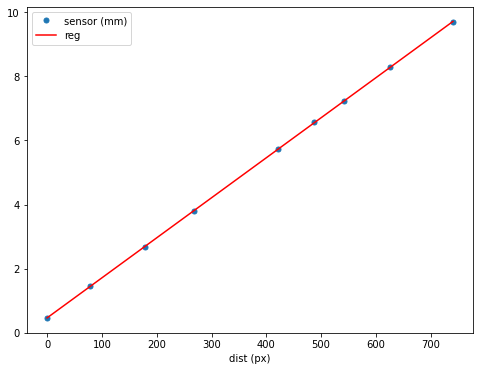

In [18]:
# aruco vs laser displacement sensor

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

#df = pd.DataFrame(
#    {
#        "file name": ['setup1_img1.jpg','setup1_img2.jpg','setup1_img3.jpg','setup1_img4.jpg','setup1_img5.jpg'
#                     ,'setup1_img6.jpg','setup1_img7.jpg','setup1_img8.jpg','setup1_img9.jpg'],
#        "sensor (mm)": [0.5064,1.5353,2.3412,3.4370,4.5723,5.8718,7.2475,8.3390,9.7316]
#    }
#)

#df = pd.DataFrame(
#    {
#        "file name": ['setup2_img1.jpg','setup2_img2.jpg','setup2_img3.jpg','setup2_img4.jpg','setup2_img5.jpg'
#                     ,'setup2_img6.jpg','setup2_img7.jpg','setup2_img8.jpg','setup2_img9.jpg'],
#        "sensor (mm)": [0.5393,1.6483,2.8225,3.7052,4.8530,6.0415,7.2658,8.4812,9.6174]
#    }
#)

#df = pd.DataFrame(
#    {
#        "file name": ['setup3_img1.jpg','setup3_img2.jpg','setup3_img3.jpg','setup3_img4.jpg','setup3_img5.jpg'
#                     ,'setup3_img6.jpg','setup3_img7.jpg','setup3_img8.jpg','setup3_img9.jpg'],
#        "sensor (mm)": [0.7023,2.1092,2.9332,4.2508,5.2229,6.3942,7.8878,8.8936,9.7511]
#    }
#)

#df = pd.DataFrame(
#    {
#        "file name": ['setup4_img1.jpg','setup4_img2.jpg','setup4_img3.jpg','setup4_img4.jpg','setup4_img5.jpg'
#                     ,'setup4_img6.jpg','setup4_img7.jpg','setup4_img8.jpg','setup4_img9.jpg'],
#       "sensor (mm)": [0.2644,1.5617,3.0174,4.2728,5.6098,6.8563,7.5603,8.6505,9.9494]
#    }
#)

df = pd.DataFrame(
    {
        "file name": ['setup5_img1.jpg','setup5_img2.jpg','setup5_img3.jpg','setup5_img4.jpg','setup5_img5.jpg'
                     ,'setup5_img6.jpg','setup5_img7.jpg','setup5_img8.jpg','setup5_img9.jpg'],
        "sensor (mm)": [0.4588,1.4462,2.6874,3.8038,5.7312,6.5623,7.2250,8.2916,9.7053]
    }
)

df.insert(2,"cX",0)
df.insert(3,"cY",0)
df.insert(4,"dist (px)",0)

aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_100)
# marker created via cv2.aruco.drawMarker(aruco_dict, 1, 8)
images = glob.glob('aruco/undistorted/setup5*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret,gray_thresh = cv2.threshold(gray,50,255,cv2.THRESH_BINARY)
    fname_short = fname.rsplit("/")[2]
    aruco_params = cv2.aruco.DetectorParameters_create()
    corners = cv2.aruco.detectMarkers(gray_thresh, aruco_dict, parameters=aruco_params)
    cX = (corners[0][0][0][0][0] + corners[0][0][0][2][0]) / 2.0
    cY = (corners[0][0][0][0][1] + corners[0][0][0][2][1]) / 2.0
    df.loc[df.index[df["file name"].str.contains(fname_short)][0],"cX"] = cX
    df.loc[df.index[df["file name"].str.contains(fname_short)][0],"cY"] = cY
    
cX_zero = df.loc[0, "cX"]
cY_zero = df.loc[0, "cY"]
for fname in images:
    fname_short = fname.rsplit("/")[2]
    cX = df.loc[df.index[df["file name"].str.contains(fname_short)][0],"cX"] 
    cY = df.loc[df.index[df["file name"].str.contains(fname_short)][0],"cY"] 
    df.loc[df.index[df["file name"].str.contains(fname_short)][0],"dist (px)"] = ((cX - cX_zero)**2 + (cY - cY_zero)**2)**(1/2)
    

d = np.polyfit(df['dist (px)'],df['sensor (mm)'],1)
f = np.poly1d(d)
df.insert(5,'reg',f(df['dist (px)']))
ax = df.plot(x='dist (px)',y='sensor (mm)',style='o',ms=5,figsize=(8,6))
df.plot(x='dist (px)',y='reg',color='Red',ax=ax)

df.insert(6,'error (mm)',df['sensor (mm)'] - df['reg'])

print(df['error (mm)'])

print((df['error (mm)']).std())

print(d)
plt.savefig('aruco_cal.png', dpi=100)